# 0.0 IMPORTS

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import inflection
import math
import datetime
import re
import random
import warnings
import pickle

from matplotlib             import gridspec
from tabulate               import tabulate
from IPython.display        import Image
from scipy                  import stats as ss
from boruta                 import BorutaPy
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.ensemble       import RandomForestRegressor 


warnings.filterwarnings('ignore')
%matplotlib inline

## 0.1. Helper Functions

In [6]:
def mean_percentage_error(y, yhat):
  return np.mean((y - yhat)/y)

def mean_absolute_percentage_error(y, yhat):
    mape = np.abs(yhat - y) / y
    return np.mean(mape, axis=0)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])
                         
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    # \chi ^{2} is derived from Pearson's chi-squared test
    chi2 = ss.chi2_contingency(cm)[0]
    phi2 = chi2/n
    phi2corr  = max(0, phi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)

    # Varia de 0 a 1
    return np.sqrt(phi2corr/min(kcorr-1, rcorr-1))

def time_series_cross_validation(x_train_ts, kfold, model, verbose=False):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in range(kfold, 0, -1):
    if verbose:
      print('\nKFold Number: {}'.format(k))
    # start and end date for validation
    validation_start_date = x_train_ts['date'].max() -datetime.timedelta(days=k*6*7)
    validation_end_date = x_train_ts['date'].max() -datetime.timedelta(days=(k-1)*6*7)

    # filtering dataset
    training_data = x_train_ts[x_train_ts['date'] < validation_start_date]
    validation_data = x_train_ts[(x_train_ts['date'] >= validation_start_date) & ((x_train_ts['date'] <= validation_end_date))]

    # training dataset
    x_training = training_data.drop(['date', 'sales'], axis=1)
    y_training = training_data['sales']

    # validation dataser
    x_validation = validation_data.drop(['date', 'sales'], axis=1)
    y_validation = validation_data['sales']

    # model
    m = model.fit( x_training, y_training )

    # prediction
    yhat = m.predict( x_validation )

    # performance
    m_result = ml_error( '', np.expm1( y_validation ), np.expm1( yhat ) )

    # store performance of each kfold iteration 
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', model.__class__.__name__)).split()
  model_name = " ".join(n for n in splitted)

  return pd.DataFrame({'Model Name':	[model_name], 
    'MAE CV': [str(np.round(np.mean(mae_list),2)) + ' +/- ' + str(np.round(np.std(mae_list),2))],
    'MAPE CV': [str(np.round(np.mean(mape_list),2)) + ' +/- ' + str(np.round(np.std(mape_list),2))],
    'RMSE CV': [str(np.round(np.mean(rmse_list),2)) + ' +/- ' + str(np.round(np.std(rmse_list),2))]})

## 0.2. Loading df1

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)

df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# show first 5 rows
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [15]:
# Pra não precisar rodar o notebook novamente do zero
# A cada nova seção é recomendado criar uma cópia do conjunto de dados
df1 = df_raw.copy()

## 1.1. Rename Columns

In [17]:
# Converter colunas do estilo camel case para snake case
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [18]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 1.2 Data Dimension

In [19]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Cols {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Cols 18


## 1.3 Data Types

In [20]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [21]:
df1.isna().sum()
# Maneiras de tratar NAs
# 1. Descartar -> rápido mas há perda de dados, podendo prejudicar a performance do modelo
# 2. Usando algoritmos de ML -> Substituir as colunas vazia pelo próprio comportamento da coluna
# 3. Entendendo o negócio pode haver uma regra para preencher os dados faltantes

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NAs

In [22]:
df1['competition_distance'].max()

75860.0

In [23]:
# Whereas when competition_distance = Na, there is no close competitor
# competition_distance pode estar vazia porque pode não ter um compedidor próximo, esqueceram de preencher
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# Não tem muita lógica, mas foi feita as assumptions abaixo
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                         
# promo2_since_week               
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval                  
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                       0, axis =1) 

In [24]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types
Ao criar novas colunas é importante checar de novo o tipo das colunas, pois o resultado das operações pode ter alterado o tipo original

In [25]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Staristical


In [26]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [27]:
# Central Tendency - mean, median
num_attributes.describe().T
ct1 = pd.DataFrame(num_attributes.mean()).T
ct2 = pd.DataFrame(num_attributes.median()).T

# Dispersion - sdt, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.std()).T
d2 = pd.DataFrame(num_attributes.min()).T
d3 = pd.DataFrame(num_attributes.max()).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


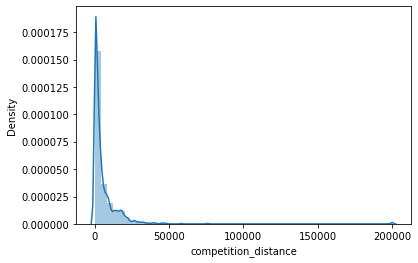

In [28]:
sns.distplot(df1['competition_distance']);

### 1.7.2 Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# Boxplots são úteis para vizualizar medidas de dispersão e tendencia central em um gráfico apenas

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

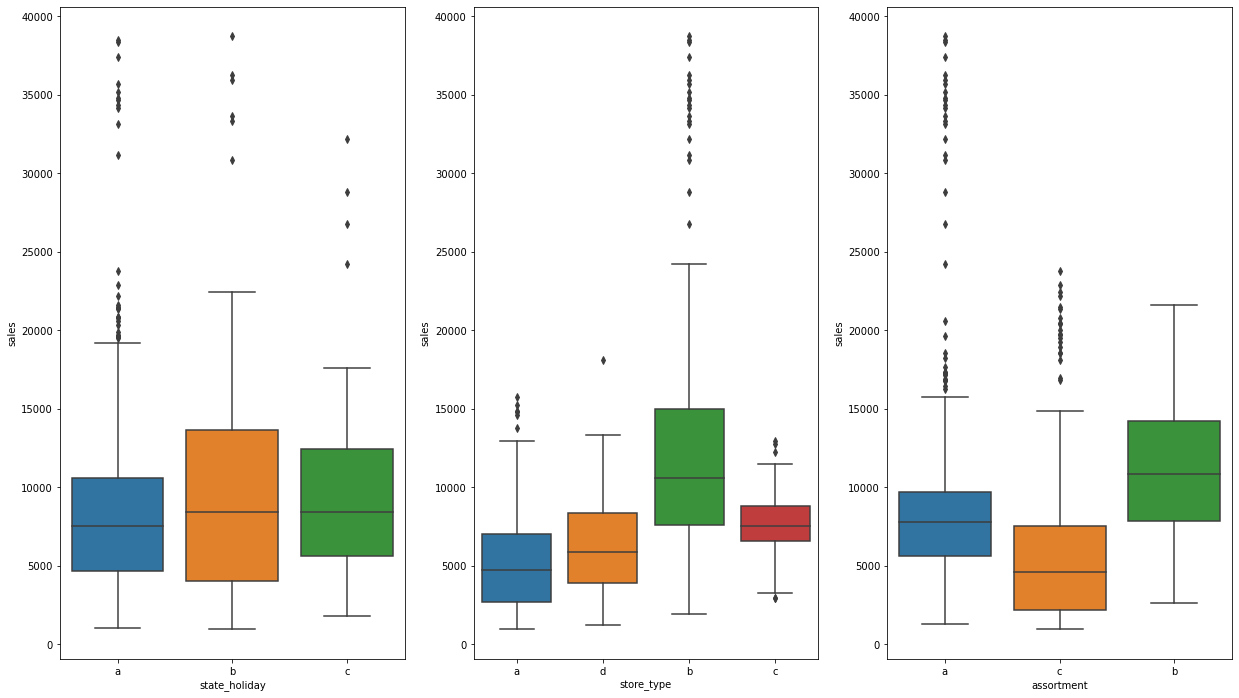

In [30]:
# Filtrar apenas registros em dias comerciais com vendas superiores a 0
aux1 =df1[(df1.state_holiday !='0' ) & (df1.sales > 0)]

# Boxplots
# Linha do meio é a mediana
# box limitado pelos 25th quartil and 75th quartil
# Outliers fora do boxplot

fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row
ax2 = fig.add_subplot(specs[0,1])  # First row Second Column
ax3 = fig.add_subplot(specs[0,2])  # First row Third Column

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=ax1)

sns.boxplot(x='store_type', y='sales', data=aux1, ax=ax2)

sns.boxplot(x='assortment', y='sales', data=aux1, ax=ax3)

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental das Hipóteses

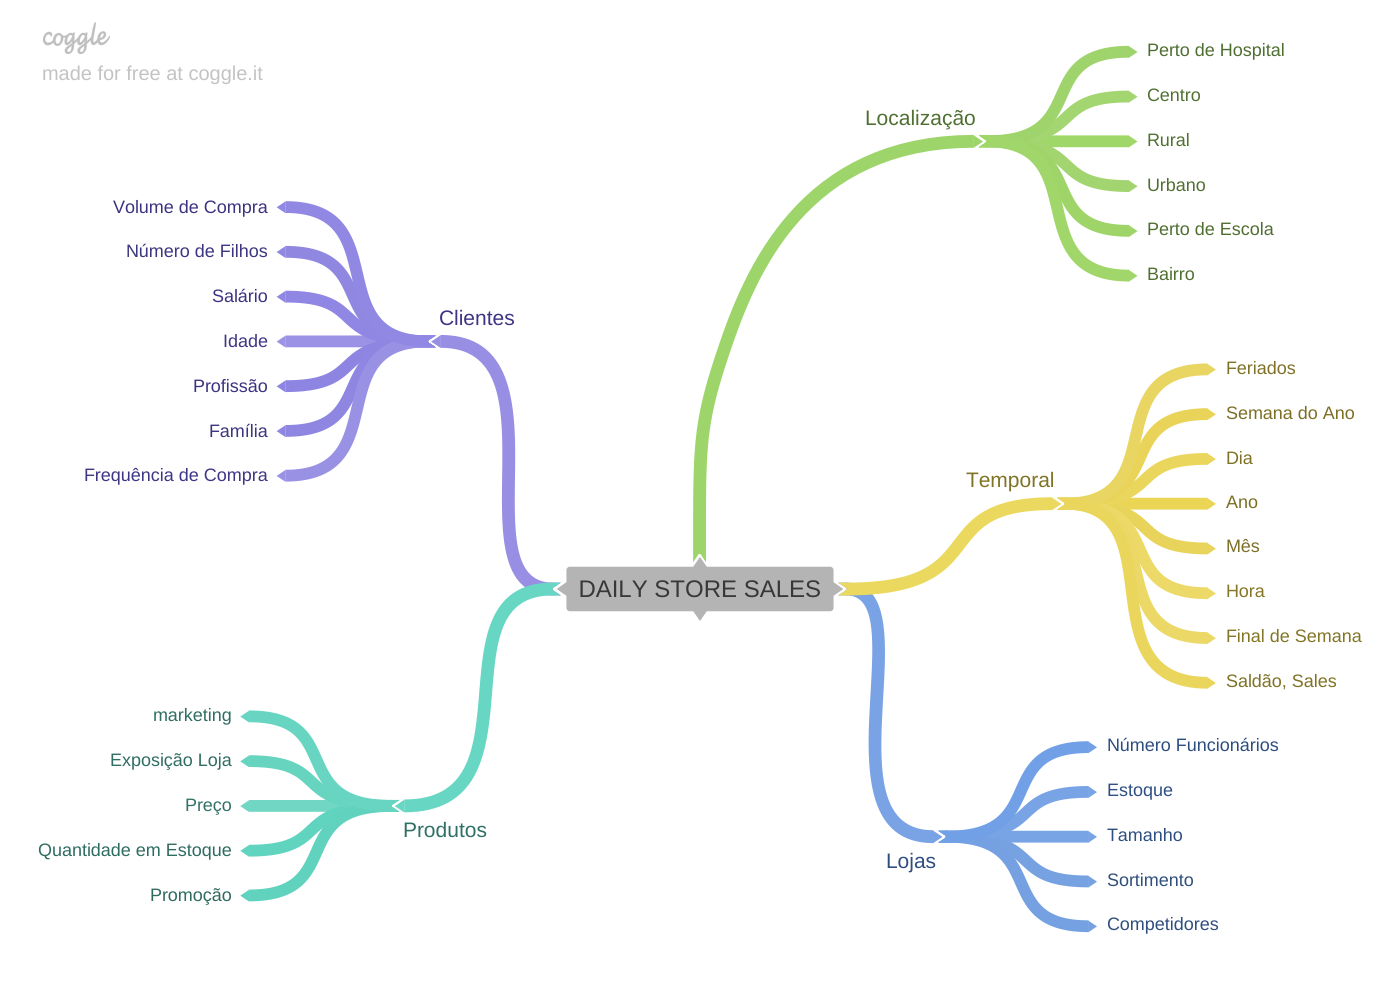

In [31]:
Image('../img/MindMapHypothesis.png')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expõem mais os produtos na vitrine deveriam vender mais

**3.** Lojas com preços menores dos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais

**5.** Lojas com promoções dos produtos por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de Hipóteses

Como prioriar as hipóteses?
	
	1. Você possui os dados da hipótese agora?

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções dos produtos por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

##

## 2.3 Feature Engineering

In [32]:
df2 = df1.copy()

In [33]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype(np.int64)

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/np.timedelta64(1,'M'))
# df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo sinxe
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# slow way
# df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7)) 
df2['promo_since'] = pd.to_datetime(df2['promo_since'] + '-1', format='%Y-%W-%w') - datetime.timedelta(days=7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/np.timedelta64(1,'W'))
# df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# # assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [34]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.000000,280.000000,558.000000,838.000000,1115.000000
day_of_week,1017209.0,3.998341,1.997391,1.000000,2.000000,4.000000,6.000000,7.000000
sales,1017209.0,5773.818972,3849.926175,0.000000,3727.000000,5744.000000,7856.000000,41551.000000
customers,1017209.0,633.145946,464.411734,0.000000,405.000000,609.000000,837.000000,7388.000000
open,1017209.0,0.830107,0.375539,0.000000,1.000000,1.000000,1.000000,1.000000
promo,1017209.0,0.381515,0.485759,0.000000,0.000000,0.000000,1.000000,1.000000
school_holiday,1017209.0,0.178647,0.383056,0.000000,0.000000,0.000000,0.000000,1.000000
competition_distance,1017209.0,5935.442677,12547.652996,20.000000,710.000000,2330.000000,6910.000000,200000.000000
competition_open_since_month,1017209.0,6.786849,3.311087,1.000000,4.000000,7.000000,10.000000,12.000000
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.000000,2008.000000,2012.000000,2014.000000,2015.000000


# 3.0 FEATURE FILTERING

In [35]:
df3 =df2.copy()

## 3.1. Filtragem da Linhas

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção da Colunas

In [37]:
# Para realizar previsão de vendas teria que ter a quantidade de customers no futuro
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Step 04 - Exploratory Data Analysis

In [38]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

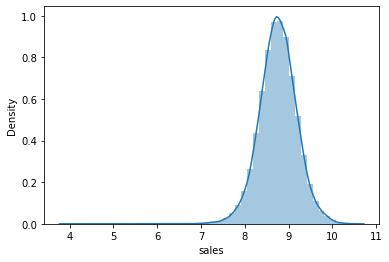

In [39]:
sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Numerical Variable

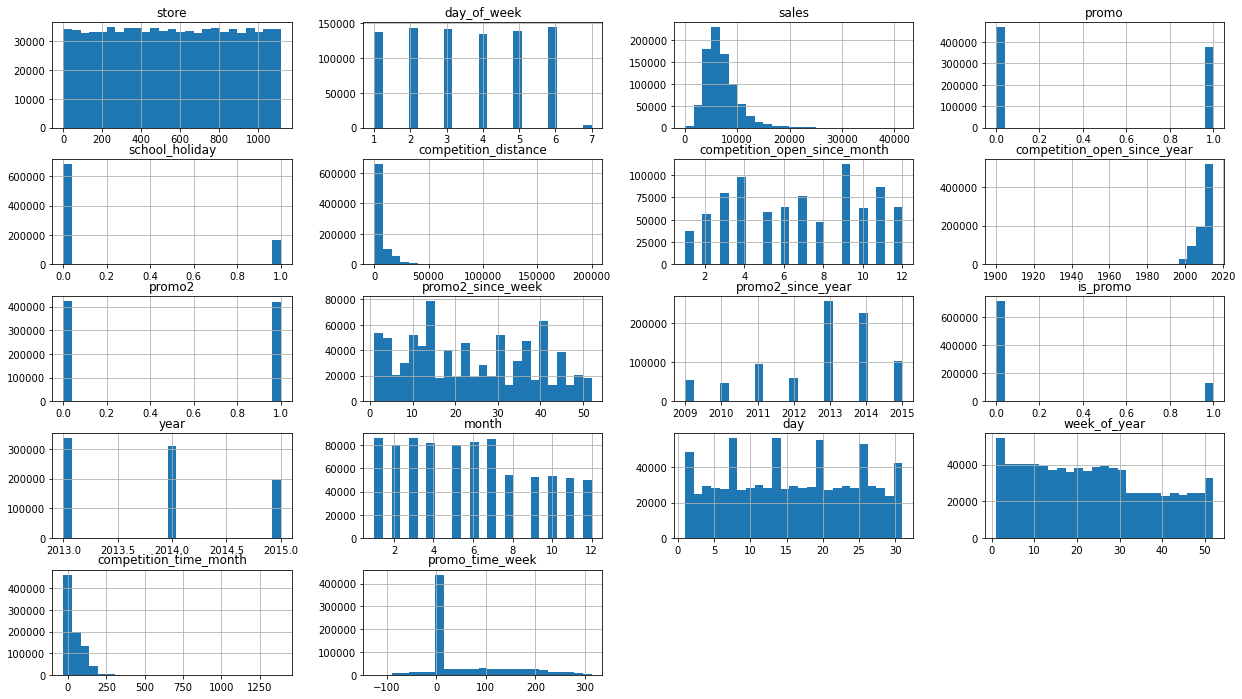

In [40]:
fig = plt.figure(figsize=(21,12));
ax = fig.add_subplot();

num_attributes = df4.select_dtypes(include=['int64', 'float64']);

num_attributes.hist(bins=25, ax=ax);

### 4.1.3. Categorical Variable

In [41]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


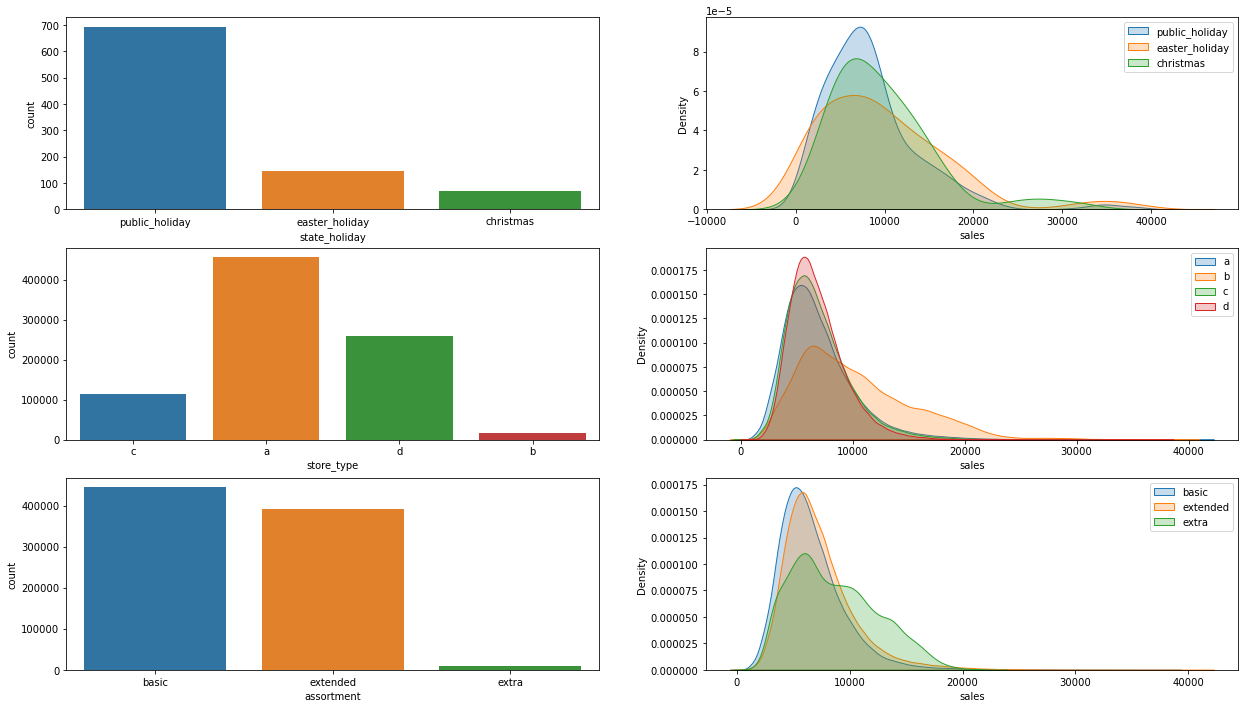

In [42]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=2, nrows=3, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row First Column
ax2 = fig.add_subplot(specs[0,1])  # First row Second Column
ax3 = fig.add_subplot(specs[1,0])  # Second row First Column
ax4 = fig.add_subplot(specs[1,1])  # Second row Second Column
ax5 = fig.add_subplot(specs[2,0])  # Third row First Column
ax6 = fig.add_subplot(specs[2,1])  # Third row Second Column

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'], ax=ax1)

# plots de densidade de distribuição
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade= True, ax=ax2)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade= True, ax=ax2)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade= True, ax=ax2)
ax2.legend()

sns.countplot(x=df4['store_type'], ax=ax3)

# plots de densidade de distribuição
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade= True, ax=ax4)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade= True, ax=ax4)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade= True, ax=ax4)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade= True, ax=ax4)
ax4.legend()

sns.countplot(x=df4['assortment'], ax=ax5)

# plots de densidade de distribuição
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade= True, ax=ax6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade= True, ax=ax6)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade= True, ax=ax6)
ax6.legend()

## 4.2. Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais, na média.
**Verdadeira** lojas com maior sortimento vendem mais na média 

<AxesSubplot:xlabel='year_week'>

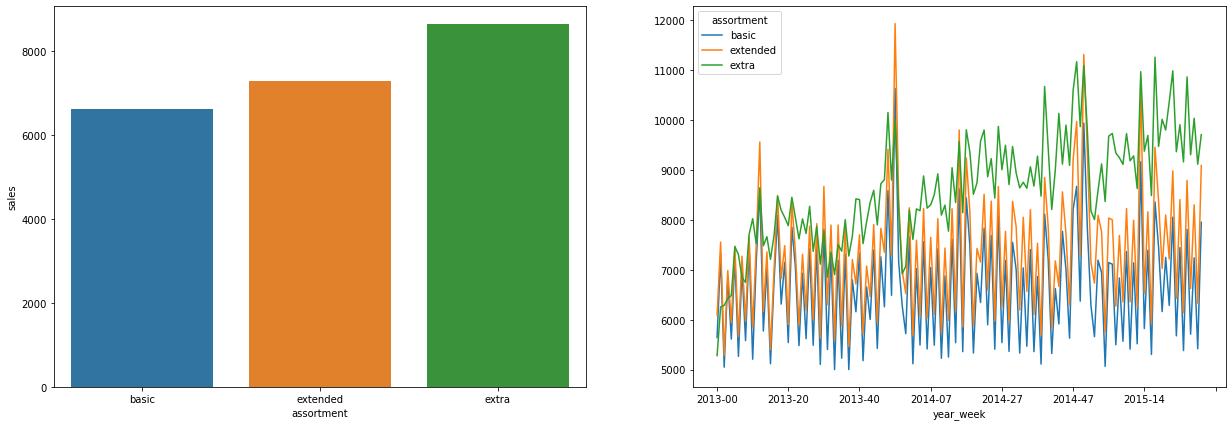

In [43]:
fig = plt.figure(figsize=(21,7))
specs = gridspec.GridSpec(ncols=2, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  
ax2 = fig.add_subplot(specs[0,1])   


aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, ax=ax1); 

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax2)

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falso**, lojas com vendedores próximos vendem mais na média

<AxesSubplot:>

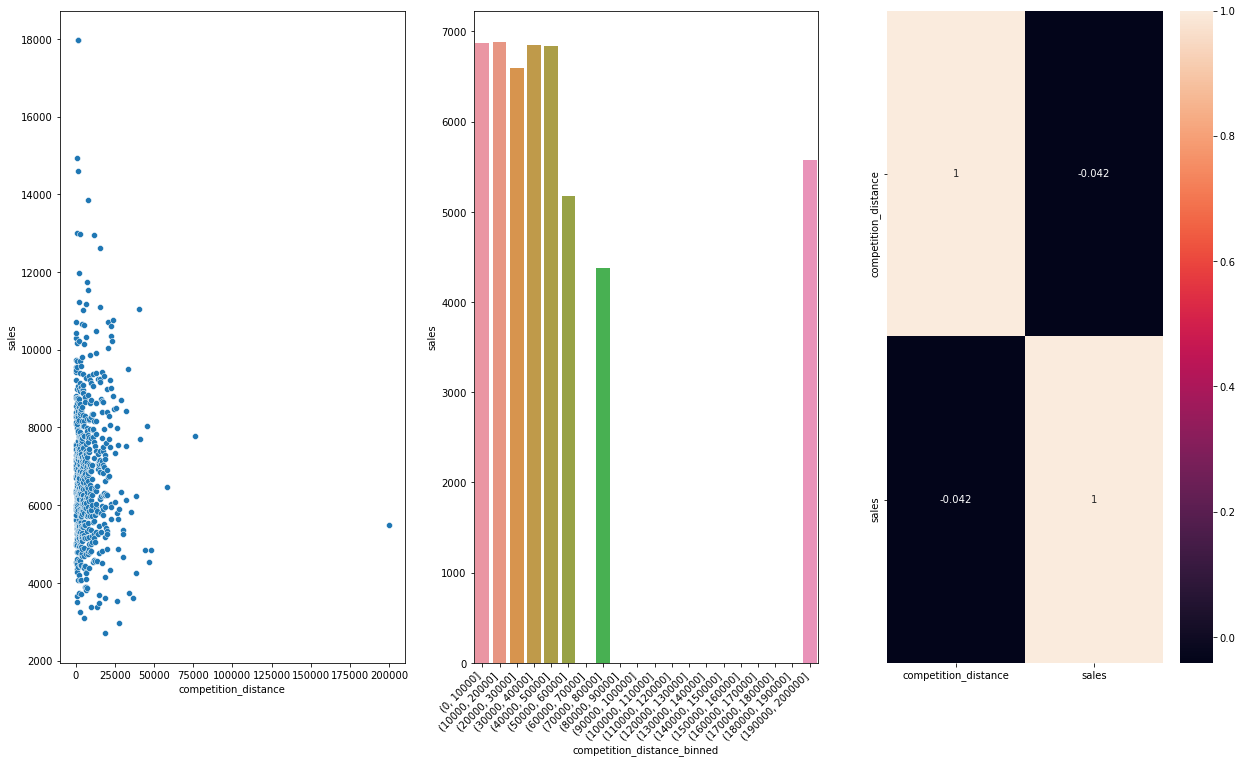

In [44]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row 
ax2 = fig.add_subplot(specs[0,1])  # Second row 
ax3 = fig.add_subplot(specs[0,2])  # Third row 


aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

sns.scatterplot(data=aux1, x='competition_distance', y='sales', ax=ax1)

bins = list(np.arange(0, 210000, 10000))

aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()


sns.barplot(x='competition_distance_binned', y='sales', data=aux2, ax=ax2); 
ax2.set_xticklabels(labels=aux2['competition_distance_binned'], rotation=45, ha='right')

sns.heatmap(df4[['competition_distance', 'sales']].corr(method='pearson'), annot=True, ax=ax3)

### **H3.** Lojas com competidores à mais tempo deveriam vender mais na média.
**Verdadeiro**

<AxesSubplot:>

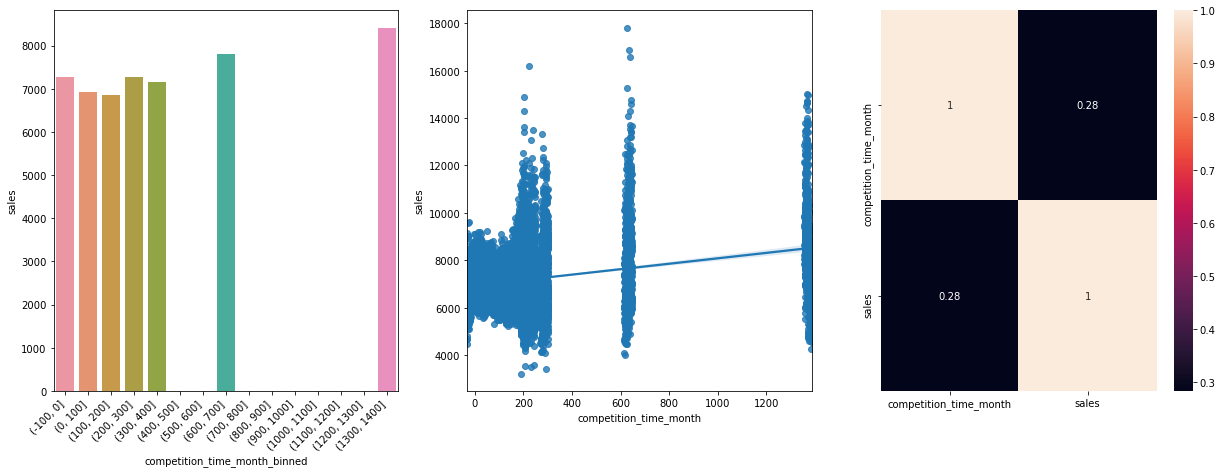

In [45]:
fig = plt.figure(figsize=(21,7))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row 
ax2 = fig.add_subplot(specs[0,1])  # Second row 
ax3 = fig.add_subplot(specs[0,2])  # Third row 

aux1 = df4.copy()
bins = list(np.arange(-100, 1500, 100))
aux1['competition_time_month_binned'] = pd.cut(df4['competition_time_month'], bins=bins)
aux2 = aux1[['competition_time_month_binned', 'sales']].groupby('competition_time_month_binned').mean().reset_index()

sns.barplot( x='competition_time_month_binned', y='sales', data=aux2, ax=ax1 );
ax1.set_xticklabels(labels=aux2['competition_time_month_binned'], rotation=45, ha='right');

aux3 = aux1[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
sns.regplot(x='competition_time_month', y='sales', data=aux3, ax= ax2)

sns.heatmap(aux3.corr(method='pearson'), annot=True, ax=ax3)

### **H4.** Lojas com promoções dos produtos por mais tempo deveriam vender mais.

**Verdadeiro** para promoções extendidas e **falso** para promoções regulares, pois para períodos de promoções regulares a correlação é quase nula

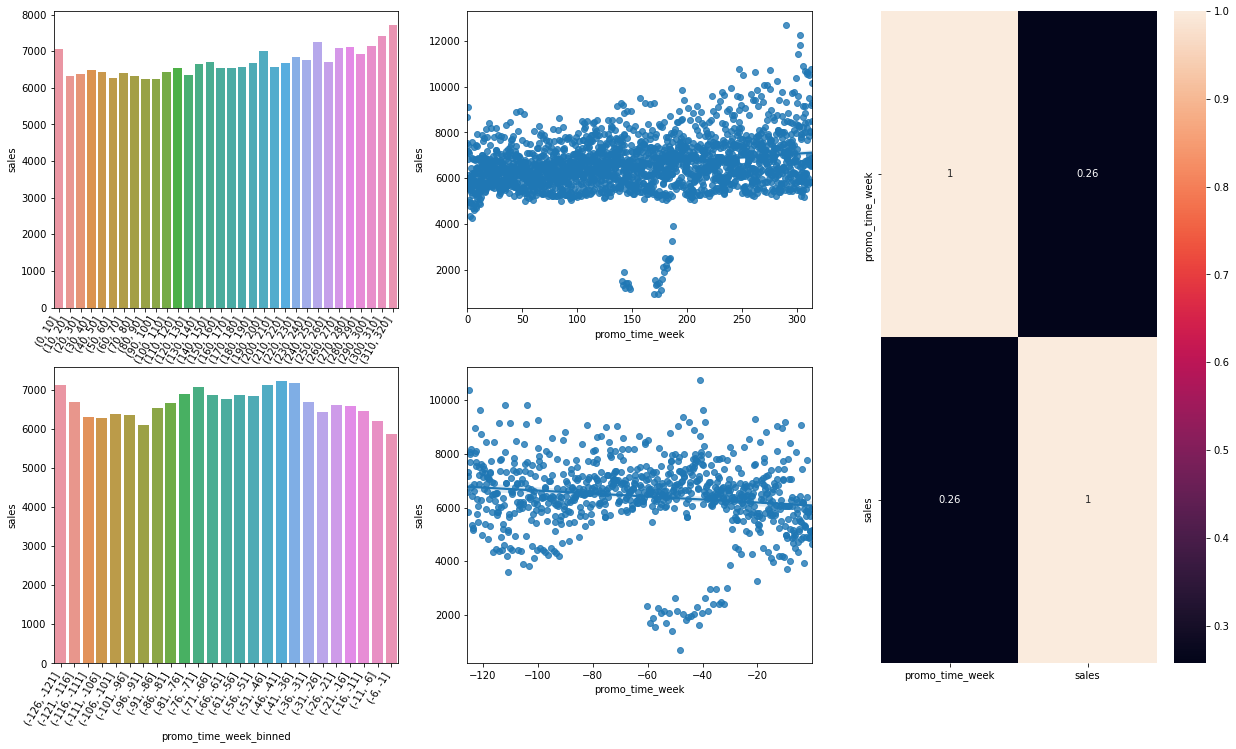

In [46]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=2, figure = fig)

ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[0,1])
ax3 = fig.add_subplot(specs[1,0])
ax4 = fig.add_subplot(specs[1,1])
ax5 = fig.add_subplot(specs[:,2])

bins = list(np.arange(0, 330, 10)); # promo extendido
aux1 = df4[df4['promo_time_week'] >= 0].copy()
aux1['promo_time_week_binned']= pd.cut(aux1['promo_time_week'], bins=bins)
aux2 = aux1[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot( x='promo_time_week_binned', y='sales', data=aux2, ax=ax1)
ax1.set_xticklabels(labels=aux2['promo_time_week_binned'], rotation=60, ha='right')

aux3 = aux1[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
sns.regplot(x='promo_time_week', y='sales', data=aux3, ax= ax2)

bins = list(np.arange(-126, 0, 5)); # promo regular
aux4 = df4[df4['promo_time_week'] < 0].copy()
aux4['promo_time_week_binned'] = pd.cut(aux4['promo_time_week'], bins=bins)
aux5 = aux4[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot( x='promo_time_week_binned', y='sales', data=aux5, ax=ax3)
ax3.set_xticklabels(labels=aux5['promo_time_week_binned'], rotation=60, ha='right')

aux6 = aux4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
sns.regplot(x='promo_time_week', y='sales', data=aux6, ax= ax4)

sns.heatmap(aux3.corr(method='pearson'), annot=True, ax=ax5);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais </s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais

**Falso** Lojas com mais promocoes consecutivas vendem menos

In [47]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


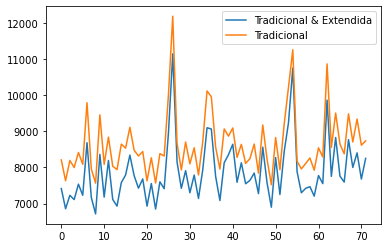

In [48]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa**, Lojas abertas durante a páscoa vendem mais na média

<AxesSubplot:xlabel='year', ylabel='sales'>

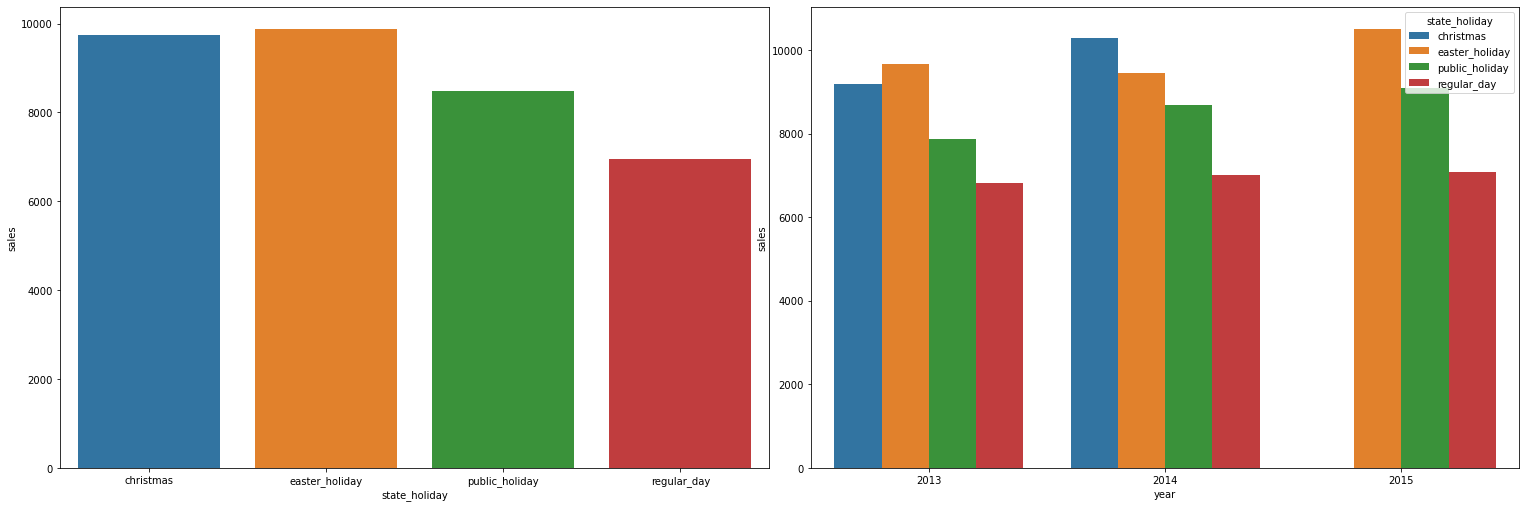

In [49]:
#define subplots
fig, ax = plt.subplots(1, 2, figsize=(21,7))
fig.tight_layout()

aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, ax=ax[0])

aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2,ax=ax[1])

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Falsa**, as vendas das lojas diminuem com o passar dos anos

<AxesSubplot:>

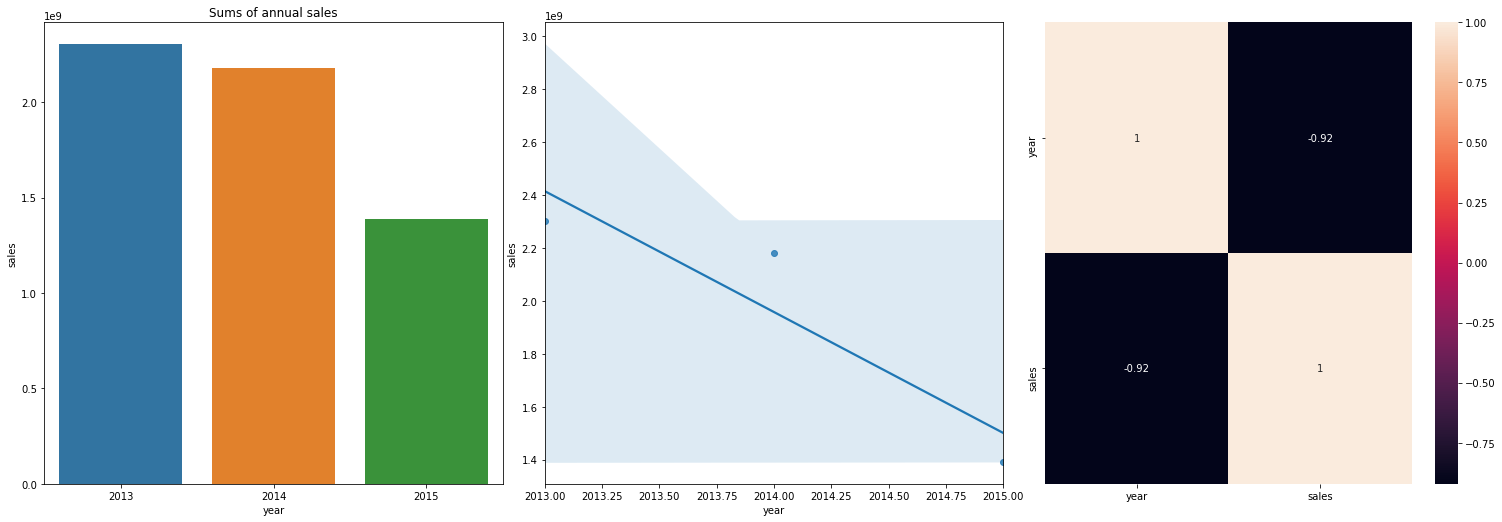

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
fig.tight_layout()

# aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()
# sns.barplot(x='year', y='sales', data=aux1, ax=ax[0,0]).set(title='Average annual sales')
# sns.regplot(x='year', y='sales', data=aux1, ax=ax[0,1])
# sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[0,2])

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1, ax=ax[0]).set(title='Sums of annual sales')
sns.regplot(x='year', y='sales', data=aux1, ax=ax[1])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])

### **H9.** Lojas demveriam vender mais no segundo semestre do ano.
**Verdadeiro**, na média, as lojas vendem mais no segundo semestre

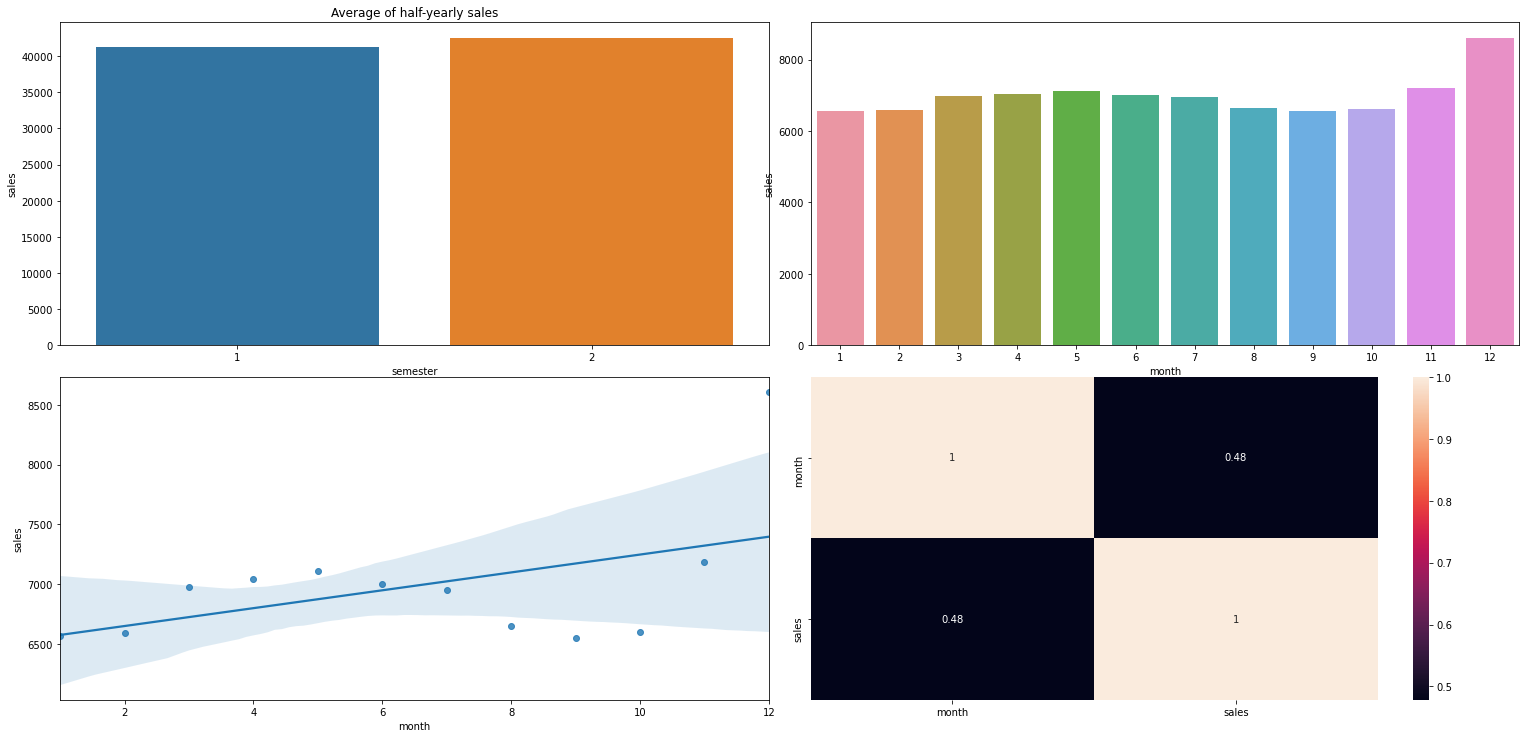

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()
avg_sales_first_sem = aux1[aux1['month'] <= 6]['sales'].sum()
avg_sales_second_sem = aux1[aux1['month'] > 6]['sales'].sum()

df= pd.DataFrame(data= {'sales': [avg_sales_first_sem, avg_sales_second_sem], 'semester': [1, 2]})

sns.barplot(x='semester', y='sales', data =df, ax=ax[0,0]).set(title='Average of half-yearly sales')

sns.barplot( x='month', y='sales', data=aux1 , ax=ax[0,1]);

sns.regplot( x='month', y='sales', data=aux1, ax=ax[1,0]);

sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

<AxesSubplot:xlabel='before_after_10', ylabel='sales'>

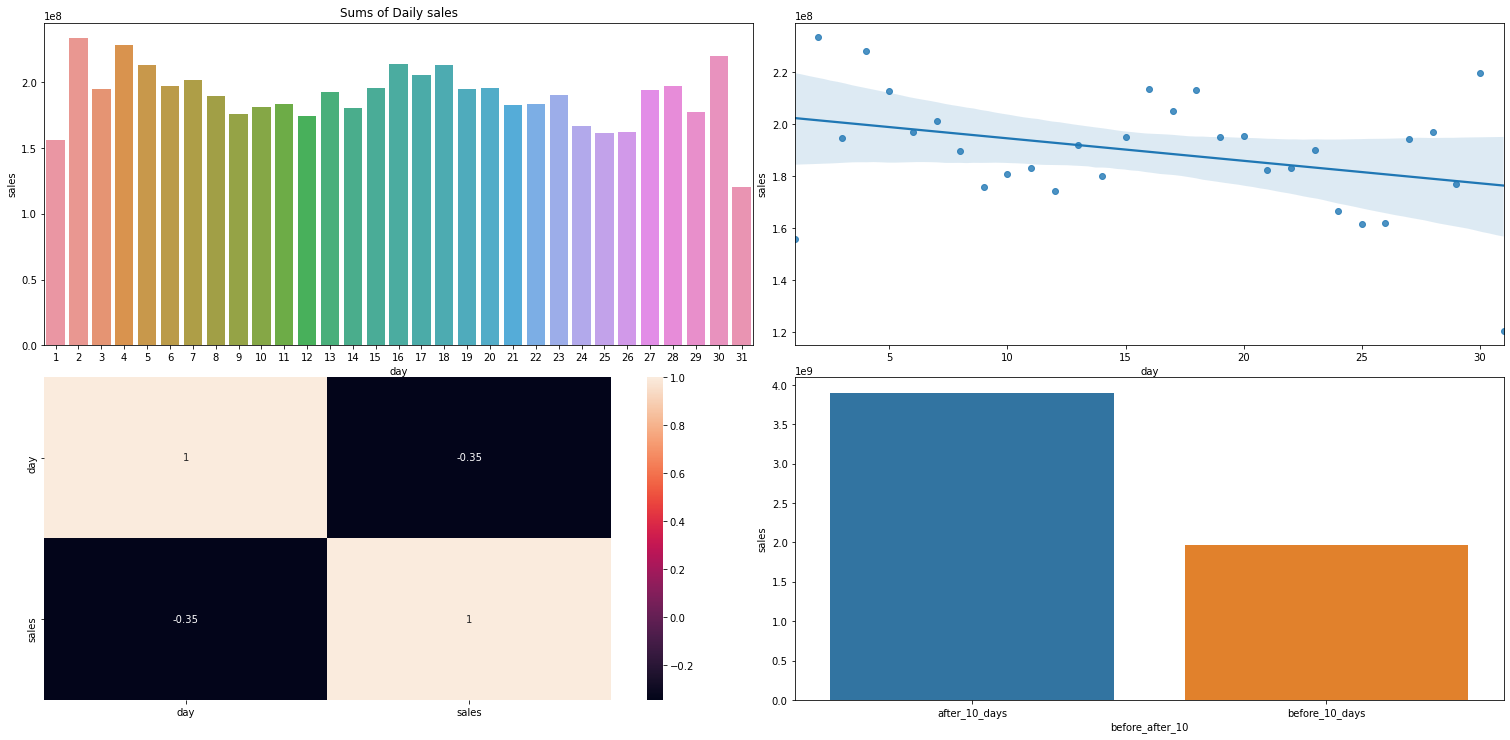

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1, ax=ax[0,0]).set(title='Sums of Daily sales')
sns.regplot(x='day', y='sales', data=aux1, ax=ax[0,1])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[1,0])

aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after_10', 'sales']].groupby( 'before_after_10' ).sum().reset_index()
sns.barplot(x='before_after_10', y='sales', data=aux2, ax=ax[1,1])

### **H11.** Lojas deveriam vender menos nos finais de semana.

**VERDADEIRA** Lojas vendem menos nos final de semana

<AxesSubplot:>

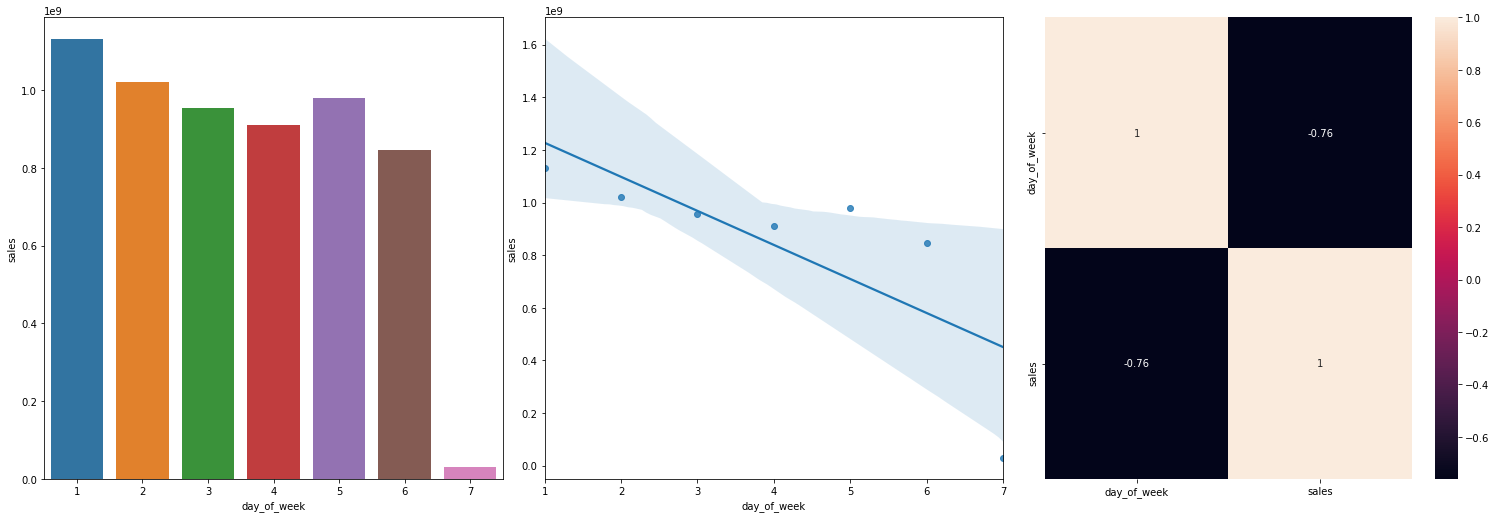

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
fig.tight_layout()


aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1, ax=ax[0])
sns.regplot(x='day_of_week', y='sales', data=aux1, ax=ax[1])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos meses de Agosto

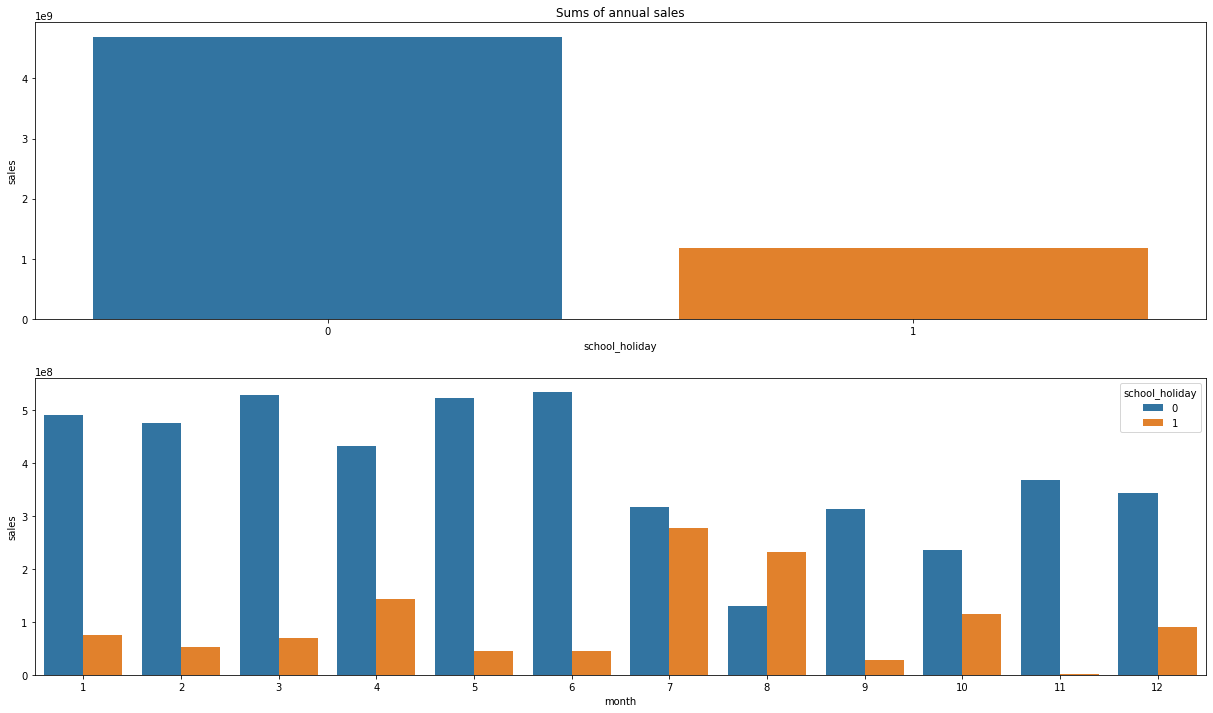

In [54]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=1, nrows=2, figure = fig)

ax1 = fig.add_subplot(specs[0])
ax2 = fig.add_subplot(specs[1])

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1, ax=ax1).set(title='Sums of annual sales')
# sns.regplot(x='school_holiday', y='sales', data=aux1, ax=ax2)
# sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax3)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 , ax=ax2);

### 4.2.1 Resumo das Hipóteses

In [55]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Verdadeira', 'Alta'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Verdadeira', 'Media'],
      ['H4', 'Verdadeira', 'Media'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Media'],
      ['H10', 'Verdadeira', 'Media'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Media
H3           Verdadeira   Media
H4           Verdadeira   Media
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Media
H10          Verdadeira   Media
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

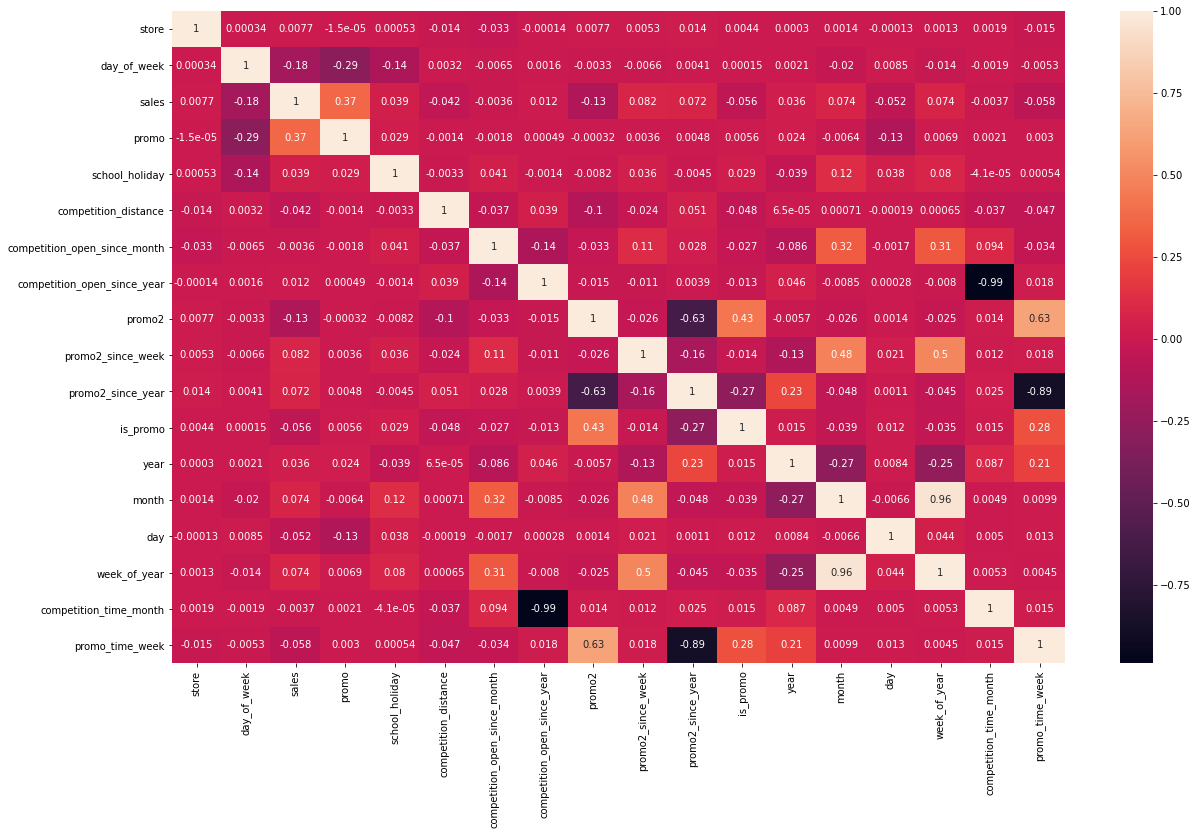

In [56]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

# creating mask
mask = np.triu(np.ones_like(num_attributes.corr()))
 
# plotting a triangle correlation heatmap
sns.heatmap(num_attributes.corr(method='pearson'), annot=True, ax=ax)

### 4.3.2 Categorical Attributes

In [57]:
cat_attributes = df4.select_dtypes(include='object')
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

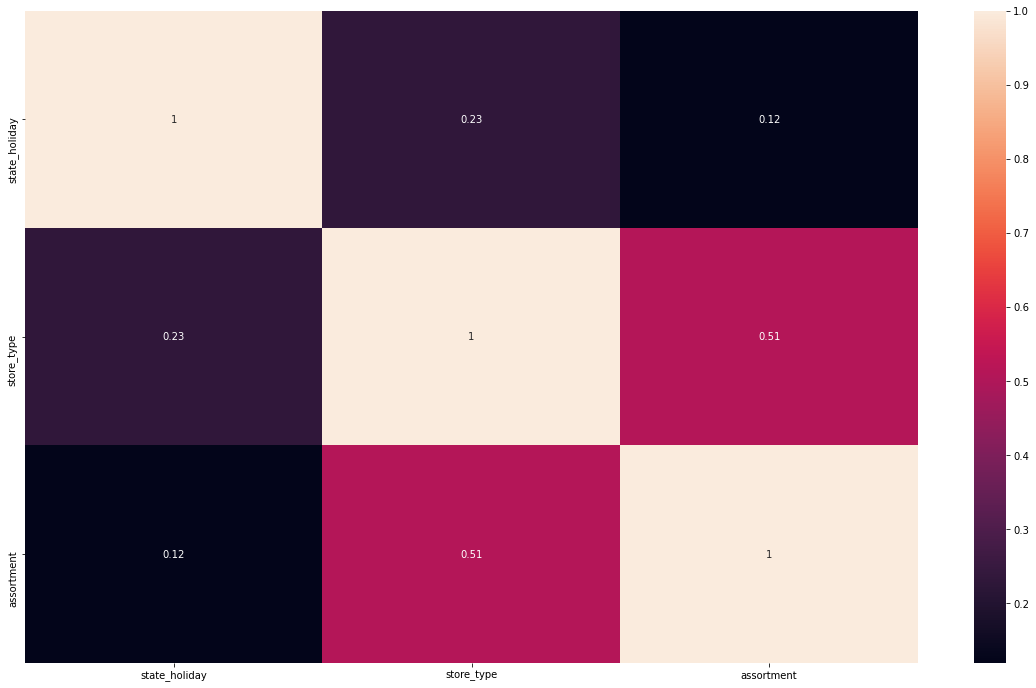

In [58]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

# only categorical data
a = a.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'] )
a8 = cramer_v(a['assortment'], a['store_type'] )
a9 = cramer_v(a['assortment'], a['assortment'] )

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )

sns.heatmap(d, annot = True, ax=ax)

# 5.0. Passo 05 - Data Preparation

In [59]:
df5 = df4.copy()

## 5.1 Normalizacao

De acordo com a análise univariada das variáveis numéricas (seção 4.1.2), não há nenhuma variável com distribuição normal ou próxima de normal. 

## 5.2 Rescaling

In [60]:
a = df5.select_dtypes(include=['int64', 'float64'])

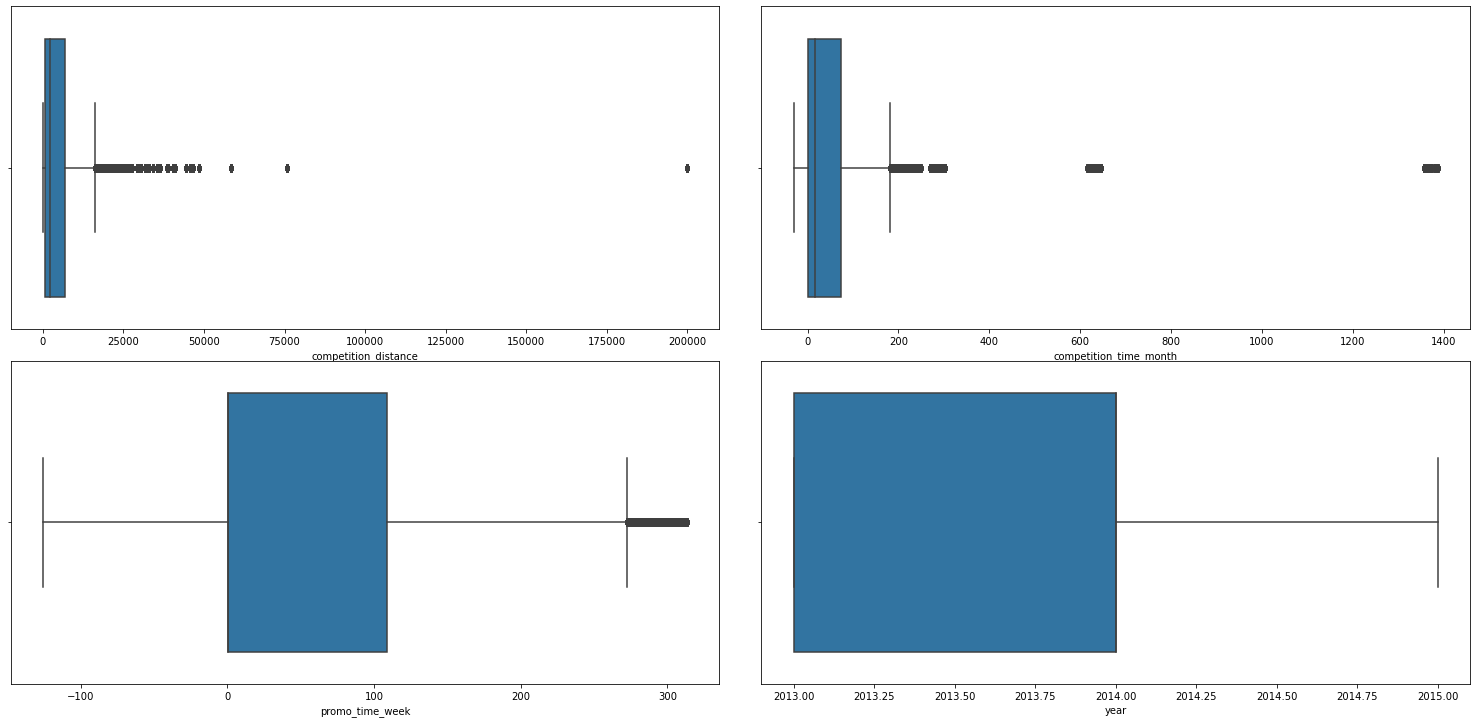

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()


sns.boxplot(x=df5['competition_distance'], ax=ax[0,0])
sns.boxplot(x=df5['competition_time_month'], ax=ax[0,1])
sns.boxplot(x=df5['promo_time_week'], ax=ax[1,0])
sns.boxplot(x=df5['year'], ax=ax[1,1]);

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])
pickle.dump( rs, open( '../parameter/competition_distance_scaler.pkl', 'wb') )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])
pickle.dump( rs, open( '../parameter/competition_time_month_scaler.pkl', 'wb') )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])
pickle.dump( rs, open( '../parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '../parameter/year_scaler.pkl', 'wb') )

## 5.3 Transformacao

### 5.3.1 Encoding

In [65]:
cat_attributes = df5.select_dtypes(include='object')
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [66]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( '../parameter/store_type_encoder.pkl', 'wb') )

# assortment -  Ordinal Encoding
assotment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assotment_dict)

### 5.3.2 Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

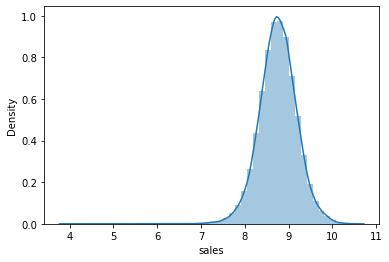

In [56]:
df5['sales'] = np.log1p(df5['sales'])

sns.distplot(df5['sales'])

### 5.3.2 Nature Transformation

In [57]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. *np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. *np.pi/12)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. *np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. *np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. *np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. *np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. *np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. *np.pi/52)))

In [58]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984


# 6.0 passo 06 - Feature Selection

In [59]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test set

In [60]:
cols_drop = ['week_of_year', 'day', 'day_of_week', 'month', 'competition_since', 'promo_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

Como estamos trabalhando com um problema temporal, não podemos selecionar aleatóriamente quais linhas pertecenrão ao conjunto de treinamento  e quais linhas pertencerão ao conjunto de testes. Como o objetivo é fazer uma previsão das vendas nas próximas 6 semanas, as últimas 6 semanas de venda serão utilizadas como teste e os dados anteriores serão utilizados com treino.

In [61]:
data_limit = df6[['store', 'date']].groupby('store').max()['date'].max() - datetime.timedelta(days=6*7)

# df_sample = df6.sample(n=400000)

# training dataset
X_train = df6[df6['date'] < data_limit]
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= data_limit]
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('\nTest Min date: {}'.format(X_test['date'].min()))
print('Test Max date: {}'.format(X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [62]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [63]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [64]:
# No primeiro cliclo do CRISP será utilizado apenas as variáveis fornecidas pelo Borutaooo

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Passo 07 - Machine Learning Modelling

In [65]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_train_ts = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales' : 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.511888,0.291615,2663.307498


Observa-se que o RMSE aumentou ao comparar com o modelo baseline que calcula a media. Assim chega-se a conclusão que os dados possuem um comportamento não linear.

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = time_series_cross_validation(x_train_ts, 5, LinearRegression())
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2078.09 +/- 295.43,0.3 +/- 0.02,2946.66 +/- 468.06


## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.398669,0.289252,2743.459417


### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = time_series_cross_validation(x_train_ts, 5, lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.17 +/- 506.07


## 7.4 Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.284546,0.100208,1020.281063


### 7.4.1 Random Fores Regressor - Cross Validation

In [ ]:
rf_result_cv = time_series_cross_validation(x_train_ts, 5, rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.8 +/- 214.98,0.12 +/- 0.02,1256.26 +/- 310.6


## 7.5 XGBoost Regressor

In [ ]:
# model
xgb_model = xgb.XGBRegressor (objective='reg:squarederror',
                       n_estimators=100,
                       eta=0.01,
                       subsample=0.7).fit(x_train, y_train)

# prediction
yhat_xgb = xgb_model.predict(x_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6685.163009,0.949099,7335.806935


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = time_series_cross_validation(x_train_ts, 5, xgb_model, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,7049.73 +/- 589.3,0.95 +/- 0.0,7718.99 +/- 689.76


## 7.6 Compare Model's Performance

### 7.6.1. Single Performance

In [ ]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.284546,0.100208,1020.281063
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1861.511888,0.291615,2663.307498
0,Linear Regression - Lasso,1891.398669,0.289252,2743.459417
0,XGBoost Regressor,6685.163009,0.949099,7335.806935


### 7.6.2 Cross Validation Performance

In [ ]:
modeling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.8 +/- 214.98,0.12 +/- 0.02,1256.26 +/- 310.6
0,Linear Regression,2078.09 +/- 295.43,0.3 +/- 0.02,2946.66 +/- 468.06
0,Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.17 +/- 506.07
0,XGB Regressor,7049.73 +/- 589.3,0.95 +/- 0.0,7718.99 +/- 689.76


# 8.0. Passo 08 - Hyperparameter Fine Tuning

Apesar de te obtido os piores resultados, seguirei nesse projeto com o XGB Regressor, que é um modelo que vem apresentando ótimos resultados em diversas competições de data science e é mais leve que o Random Forest Regressor, onde foi obtido os melhores resultados. Além disso tem muitas implementações prontas na internet para realizar fine tuning de Random Forest, mas tem poucas implementações de fine tuning do hiperparamentros do XGB Regressor. Acredito que na proxima etapa de fine tuning seja possivel melhorar consideravelmente a performance do XGB Regressor. 

## 8.1. Random Search

In [125]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]}

MAX_EVAl = 10

In [126]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAl):
#     # choose values for parameters randomly
#     selected_param =  pd.DataFrame({k: [random.sample(v, 1)[0]] for k, v in param.items()})
    
#     # model
#     xgb_model = xgb.XGBRegressor (objective='reg:squarederror',
#                                   n_estimators = selected_param['n_estimators'][0],
#                                   eta = selected_param['eta'][0],
#                                   max_depth = selected_param['max_depth'][0],
#                                   subsample = selected_param['subsample'][0],
#                                   colsample_bytree = selected_param['colsample_bytree'][0],
#                                   min_child_weight = selected_param['min_child_weight'][0]).fit(x_train, y_train)

#     # prediction
#     yhat_xgb = xgb_model.predict(x_test)

#     # performance
#     result = pd.concat([time_series_cross_validation(x_train_ts, 5, xgb_model), selected_param], axis=1)
    
#     final_result = pd.concat([final_result, result])

# final_result = final_result.sort_values('RMSE CV', ignore_index=True)
# final_result

,Model Name,MAE CV,MAPE CV,RMSE CV,n_estimators,eta,max_depth,subsample,colsample_bytree,min_child_weight
0,XGB Regressor,826.29 +/- 99.62,0.11 +/- 0.01,1200.79 +/- 172.27,2500,0.03,9,0.7,0.9,8
1,XGB Regressor,916.39 +/- 75.79,0.12 +/- 0.01,1316.21 +/- 126.66,3000,0.03,5,0.5,0.9,3
2,XGB Regressor,915.26 +/- 76.62,0.12 +/- 0.01,1328.19 +/- 149.64,3500,0.01,9,0.7,0.3,8
3,XGB Regressor,956.99 +/- 67.02,0.13 +/- 0.01,1401.51 +/- 132.2,1700,0.01,9,0.7,0.7,3
4,XGB Regressor,969.19 +/- 77.17,0.13 +/- 0.01,1410.35 +/- 147.41,2500,0.01,9,0.7,0.3,15
5,XGB Regressor,1207.5 +/- 44.11,0.16 +/- 0.0,1778.91 +/- 89.43,3000,0.01,5,0.5,0.9,8
6,XGB Regressor,1225.97 +/- 53.07,0.16 +/- 0.0,1797.44 +/- 97.91,3500,0.03,3,0.7,0.7,15
7,XGB Regressor,1453.15 +/- 54.06,0.19 +/- 0.0,2131.16 +/- 101.44,2500,0.03,3,0.7,0.3,8
8,XGB Regressor,1601.6 +/- 53.52,0.22 +/- 0.0,2335.62 +/- 99.04,1500,0.01,5,0.5,0.3,15
9,XGB Regressor,1733.77 +/- 54.31,0.23 +/- 0.0,2514.89 +/- 100.41,2500,0.01,3,0.5,0.3,8


## 8.2. Final Model

In [66]:
param_tuned = {
    'n_estimators': 2500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'min_child_weight': 8}

In [67]:
# model
xgb_model_tuned = xgb.XGBRegressor (objective='reg:squarederror',
                                    n_estimators = param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth = param_tuned['max_depth'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

pickle.dump(xgb_model_tuned, open('../model/model_rossmann.pkl', 'wb'))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,,633.873824,0.091942,927.637792


In [68]:
xgb_result_tuned = pickle.load(open('../model/model_rossmann.pkl', 'rb'))

# prediction
yhat_xgb_tuned = xgb_result_tuned.predict(x_test)

# 9.0. Passo 09 - Tradução e Interpretação do Erro

In [85]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [99]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [101]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
374,375,333364.406250,332758.565258,333970.247242,605.840992,0.066834
450,451,204685.234375,204120.252375,205250.216375,564.982000,0.095816
883,884,228058.250000,227562.607105,228553.892895,495.642895,0.077195
503,504,239968.156250,239383.264582,240553.047918,584.891668,0.081334


In [102]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105135.00000,101837.361033,108432.638967,3297.638967,0.555856
908,909,233835.56250,226144.359035,241526.765965,7691.203465,0.519649
875,876,201900.65625,197640.585088,206160.727412,4260.071162,0.331561
594,595,366067.59375,361658.258103,370476.929397,4409.335647,0.303921
721,722,349481.75000,347584.837442,351378.662558,1896.912558,0.254581


<AxesSubplot:xlabel='store', ylabel='MAPE'>

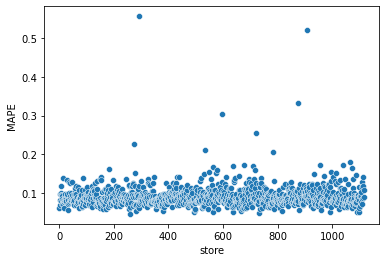

In [103]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [133]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"$283,650,944.00"
1,worst_scenario,"$282,939,996.98"
2,best_scenario,"$284,361,896.05"


## 9.3. Machine Learning Performance

In [135]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

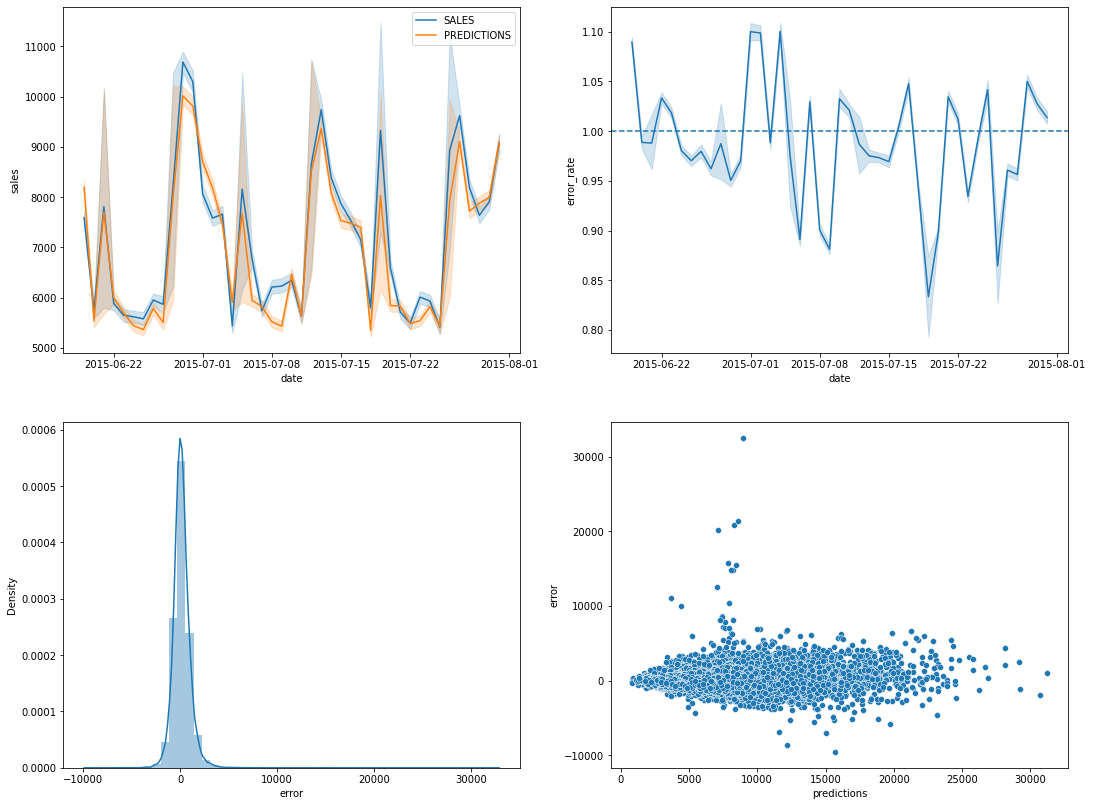

In [154]:
fig, ax = plt.subplots(2, 2, figsize=(18,14))

sns.lineplot(x='date', y='sales', data=df9, label='SALES', ax=ax[0][0])
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS', ax=ax[0][0])

graph =  sns.lineplot(x='date', y='error_rate', data=df9, ax=ax[0][1])
graph.axhline(1, linestyle='--')

sns.distplot(df9['error'], ax=ax[1][0])

sns.scatterplot(x='predictions', y='error', data=df9, ax=ax[1][1])

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

##  10.1. Rossmann Class

In [78]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):

        self.home_path='/home/leonam/Desktop/projects/DS-em-Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_encoder            = pickle.load( open( self.home_path + 'parameter/store_type_encoder.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_encoder.transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

##  10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model

model = pickle.load( open( '/home/leonam/Desktop/projects/DS-em-Producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester

In [1]:
import json
import requests

In [5]:
# loading test dataset
df10 = pd.read_csv('../data/test.csv')

In [6]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[(df_test['Open'].notnull()) & (df_test['Open'] !=0)]
df_test = df_test.drop('Id', axis=1)

In [7]:
# conver Dataframe to json
data =  json.dumps(df_test.to_dict(orient='records'))

In [13]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://leorsm-rossmann-prediction.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [14]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [15]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']
    ))

Store Number 12 will sell $231,794.10 in the next 6 weeks
Store Number 22 will sell $148,356.36 in the next 6 weeks
Store Number 24 will sell $312,009.55 in the next 6 weeks
